In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# 1. Load the macro dataset
df = pd.read_csv("day_dataset.csv")
print(f"Original Data Shape: {df.shape}")
print(f"Number of missing values: {df.isnull().sum().sum()}")

Original Data Shape: (731, 16)
Number of missing values: 0


In [6]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [7]:
# 2. Rename columns for easier understanding (optional but recommended)
df_day.rename(columns={
    'dteday': 'date', 
    'yr': 'year', 
    'mnth': 'month', 
    'weathersit': 'weather_condition',
    'temp': 'temperature',
    'hum': 'humidity', 
    'cnt': 'total_rentals'
}, inplace=True)

In [8]:
# 2. Convert date to datetime for time-series operations
df_day['date'] = pd.to_datetime(df_day['date'])

In [9]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            731 non-null    int64         
 1   date               731 non-null    datetime64[ns]
 2   season             731 non-null    int64         
 3   year               731 non-null    int64         
 4   month              731 non-null    int64         
 5   holiday            731 non-null    int64         
 6   weekday            731 non-null    int64         
 7   workingday         731 non-null    int64         
 8   weather_condition  731 non-null    int64         
 9   temperature        731 non-null    float64       
 10  atemp              731 non-null    float64       
 11  humidity           731 non-null    float64       
 12  windspeed          731 non-null    float64       
 13  casual             731 non-null    int64         
 14  registered

In [10]:
# 3. Create the 7-day Rolling Average for Temperature
# This smooths out 'one-off' cold days to find stable windows
df_day['temp_rolling_7d'] = df_day['temperature'].rolling(window=7).mean()

In [11]:
# 4. Create the 7-day Rolling Average for Demand
df_day['demand_rolling_7d'] = df_day['total_rentals'].rolling(window=7).mean()

In [12]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            731 non-null    int64         
 1   date               731 non-null    datetime64[ns]
 2   season             731 non-null    int64         
 3   year               731 non-null    int64         
 4   month              731 non-null    int64         
 5   holiday            731 non-null    int64         
 6   weekday            731 non-null    int64         
 7   workingday         731 non-null    int64         
 8   weather_condition  731 non-null    int64         
 9   temperature        731 non-null    float64       
 10  atemp              731 non-null    float64       
 11  humidity           731 non-null    float64       
 12  windspeed          731 non-null    float64       
 13  casual             731 non-null    int64         
 14  registered

In [13]:
# Drop the first 6 rows which now have NaNs from the rolling window
df_day.dropna(inplace=True)

print("Macro-trends established.")

Macro-trends established.


In [14]:
df_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725 entries, 6 to 730
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   instant            725 non-null    int64         
 1   date               725 non-null    datetime64[ns]
 2   season             725 non-null    int64         
 3   year               725 non-null    int64         
 4   month              725 non-null    int64         
 5   holiday            725 non-null    int64         
 6   weekday            725 non-null    int64         
 7   workingday         725 non-null    int64         
 8   weather_condition  725 non-null    int64         
 9   temperature        725 non-null    float64       
 10  atemp              725 non-null    float64       
 11  humidity           725 non-null    float64       
 12  windspeed          725 non-null    float64       
 13  casual             725 non-null    int64         
 14  registered     

In [15]:
# Calculate the threshold (e.g., bottom 20% of demand)
maintenance_threshold = df_day['demand_rolling_7d'].quantile(0.20)

In [16]:
# Identify days perfect for maintenance
df_day['is_maintenance_day'] = df_day['demand_rolling_7d'] < maintenance_threshold

In [17]:
# Filter to see the first few opportunities
windows = df_day[df_day['is_maintenance_day'] == True][['date', 'total_rentals', 'temp_rolling_7d']]
print(f"First 5 Maintenance Windows Found:\n{windows.head()}")

First 5 Maintenance Windows Found:
         date  total_rentals  temp_rolling_7d
6  2011-01-07           1510         0.247405
7  2011-01-08            959         0.221810
8  2011-01-09            822         0.189646
9  2011-01-10           1321         0.183142
10 2011-01-11           1263         0.178726


In [18]:
# Extract the quarter from the date
df_day['quarter'] = df_day['date'].dt.quarter

In [19]:
# Create a binary flag for severe weather
# 1 if weather is bad (3), 0 if it's manageable (1 or 2)
df_day['is_severe_weather'] = (df_day['weather_condition'] >= 3).astype(int)


In [20]:
df_day.isnull().sum()


instant               0
date                  0
season                0
year                  0
month                 0
holiday               0
weekday               0
workingday            0
weather_condition     0
temperature           0
atemp                 0
humidity              0
windspeed             0
casual                0
registered            0
total_rentals         0
temp_rolling_7d       0
demand_rolling_7d     0
is_maintenance_day    0
quarter               0
is_severe_weather     0
dtype: int64

In [21]:
# 1. Momentum: Yesterday's total rentals
df_day['rentals_yesterday'] = df_day['total_rentals'].shift(1)
# 2. Seasonality: Total rentals exactly 7 days ago
df_day['rentals_last_week'] = df_day['total_rentals'].shift(7)


In [22]:
# 3. Growth Trend: Days since the business started
# This helps the model realize 2012 is generally busier than 2011
df_day['days_since_start'] = (df_day['date'] - df_day['date'].min()).dt.days

# Drop the new NaNs created by the 7-day shift
df_day.dropna(inplace=True)

print("Strategic lags and trend index established.")

Strategic lags and trend index established.


In [23]:
# Select the macro categories for encoding
# We include 'quarter' because maintenance budgets are quarterly
categorical_features = ['season', 'weather_condition', 'weekday', 'month', 'quarter']

In [24]:
# Apply One-Hot Encoding
df_day_final = pd.get_dummies(df_day, columns=categorical_features, drop_first=True)

# Final Clean-up: Drop 'atemp' (redundant) and 'instant' (useless)
df_day_final.drop(['atemp', 'instant'], axis=1, inplace=True)

print(f"Final column count for Strategic Model: {len(df_day_final.columns)}")

Final column count for Strategic Model: 42


In [25]:
df_day_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 13 to 730
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 718 non-null    datetime64[ns]
 1   year                 718 non-null    int64         
 2   holiday              718 non-null    int64         
 3   workingday           718 non-null    int64         
 4   temperature          718 non-null    float64       
 5   humidity             718 non-null    float64       
 6   windspeed            718 non-null    float64       
 7   casual               718 non-null    int64         
 8   registered           718 non-null    int64         
 9   total_rentals        718 non-null    int64         
 10  temp_rolling_7d      718 non-null    float64       
 11  demand_rolling_7d    718 non-null    float64       
 12  is_maintenance_day   718 non-null    bool          
 13  is_severe_weather    718 non-null    in

In [26]:
# Compare average daily rentals: 2011 vs 2012
growth_check = df_day_final.groupby('year')['total_rentals'].mean()
print("Average Daily Rentals by Year:")
print(growth_check)

Average Daily Rentals by Year:
year
0    3485.105114
1    5599.934426
Name: total_rentals, dtype: float64


In [27]:
correlation = df_day_final['temperature'].corr(df_day_final['temp_rolling_7d'])
print(f"Correlation between daily temp and 7-day average: {correlation:.4f}")


Correlation between daily temp and 7-day average: 0.9419


In [28]:
# 1. Define the Target (y)
y = df_day_final['total_rentals']


In [29]:
# 2. Define the Strategic Features (X)
# We drop the Target, the Leaky components, and the raw Date
cols_to_drop = ['total_rentals', 'casual', 'registered', 'date', 'is_maintenance_day']

In [30]:
# 2. Create X (Features) and y (Target)
# We save the result of the drop into X
X = df_day_final.drop(columns=cols_to_drop)
y = df_day_final['total_rentals']

In [31]:
# 3. Final Verification
print(f"Original DataFrame: {df_day_final.shape[1]} columns")
print(f"Feature Set (X): {X.shape[1]} columns") # This should be 37

Original DataFrame: 42 columns
Feature Set (X): 37 columns


In [32]:
# Verify the "Bowl" is clean
print(f"X (Features) Count: {X.shape[1]}") # Should be 37
print(f"y (Target) Count: 1")

X (Features) Count: 37
y (Target) Count: 1


In [33]:
# Handle Boolean conversion (2025 Pandas best practice)
# XGBoost and other models prefer 1/0 over True/False
X = X.astype(float)

print(f"Final Strategic Feature Set: {X.shape[1]} columns")
print("Leakage successfully removed. No 'cheating' columns remain.")

Final Strategic Feature Set: 37 columns
Leakage successfully removed. No 'cheating' columns remain.


In [34]:
# 2025 Professional Step: Convert all Booleans to Integers (0 and 1)
# This prevents errors in models like XGBoost or Ridge
df_day_final = df_day_final.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

print("\nConversion complete. All binary flags are now 0/1.")


Conversion complete. All binary flags are now 0/1.


In [35]:
# Observe the current state
print(df_day_final.info())

<class 'pandas.core.frame.DataFrame'>
Index: 718 entries, 13 to 730
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 718 non-null    datetime64[ns]
 1   year                 718 non-null    int64         
 2   holiday              718 non-null    int64         
 3   workingday           718 non-null    int64         
 4   temperature          718 non-null    float64       
 5   humidity             718 non-null    float64       
 6   windspeed            718 non-null    float64       
 7   casual               718 non-null    int64         
 8   registered           718 non-null    int64         
 9   total_rentals        718 non-null    int64         
 10  temp_rolling_7d      718 non-null    float64       
 11  demand_rolling_7d    718 non-null    float64       
 12  is_maintenance_day   718 non-null    int64         
 13  is_severe_weather    718 non-null    in

In [36]:
# Calculate the 80% mark
split_index = int(len(X) * 0.8)

In [37]:
# Split features and target
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training on: {len(X_train)} days")
print(f"Testing on: {len(X_test)} days")

Training on: 574 days
Testing on: 144 days


In [38]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (exclude the 0/1 binary columns)
# Note: Ensure these names match your renamed columns exactly
cols_to_scale = ['temperature', 'humidity', 'windspeed', 'temp_rolling_7d', 
                 'rentals_yesterday', 'rentals_last_week', 'days_since_start']

scaler = StandardScaler()

In [39]:
# LEARN from the past (Train) and APPLY to the future (Test)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

print("Data scaled and prepared for Strategic Modeling.")

Data scaled and prepared for Strategic Modeling.


In [40]:
# Check first 5 rows and summary statistics of the scaled training features
print("First 5 rows of scaled data:")
print(X_train_scaled.head())

print("\nSummary Statistics (Verify mean is approx 0 and std is 1 for scaled columns):")
print(X_train_scaled[['temperature', 'humidity', 'windspeed', 'temp_rolling_7d', 
                     'rentals_yesterday', 'rentals_last_week', 'days_since_start']].describe())


First 5 rows of scaled data:
    year  holiday  workingday  temperature  humidity  windspeed  \
13   0.0      0.0         1.0    -1.859811 -0.589512  -0.879858   
14   0.0      0.0         0.0    -1.468379 -0.853921  -0.466463   
15   0.0      0.0         0.0    -1.477378 -0.955419  -0.065504   
16   0.0      1.0         0.0    -1.778983 -0.591718   0.007977   
17   0.0      0.0         1.0    -1.558405  1.601768  -0.613688   

    temp_rolling_7d  demand_rolling_7d  is_severe_weather  rentals_yesterday  \
13        -1.930431        1193.428571                0.0          -1.600625   
14        -1.875300        1234.714286                0.0          -1.592110   
15        -1.799998        1289.285714                0.0          -1.690313   
16        -1.779828        1243.428571                0.0          -1.715290   
17        -1.741443        1160.571429                0.0          -1.831091   

    ...  month_6  month_7  month_8  month_9  month_10  month_11  month_12  \
13  ...   

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

In [42]:
# 1. Initialize the Random Forest
# n_estimators=100: Creates 100 different trees to average results
# random_state=42: Ensures you get the same result every time you run it
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=10,      # Limits depth to prevent overfitting on 580 days of data
    n_jobs=-1,         # Uses all your CPU cores for speed
    random_state=42
)

In [43]:
# 2. Fit the Model on the Scaled Training Data
rf_model.fit(X_train_scaled, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
# 3. Predict the "Future" (the test set)
y_pred = rf_model.predict(X_test_scaled)

In [45]:
# 4. Business Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"--- Strategic Model Results (2025) ---")
print(f"Mean Absolute Error: {mae:.2f} bikes per day")
print(f"R-squared Score: {r2:.4f}")

--- Strategic Model Results (2025) ---
Mean Absolute Error: 708.91 bikes per day
R-squared Score: 0.7149


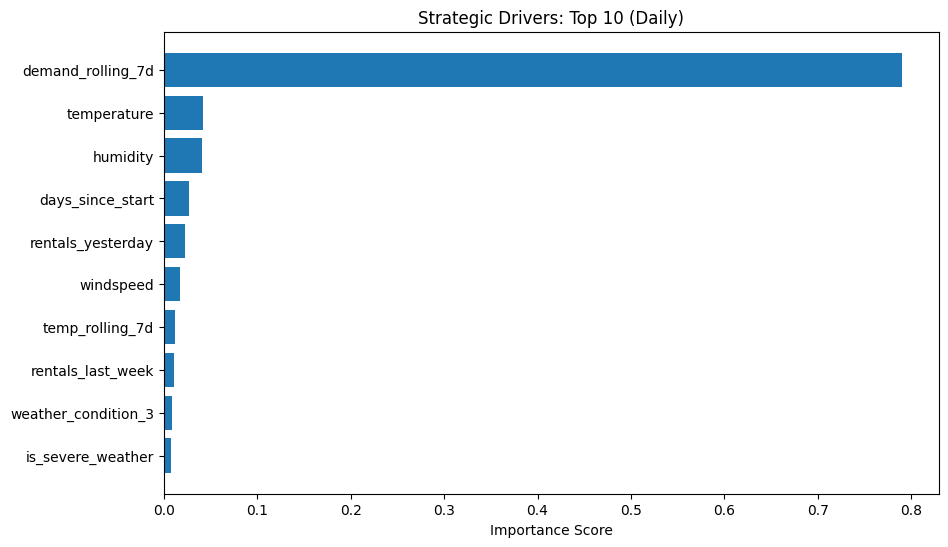

In [46]:
import matplotlib.pyplot as plt

# 1. Extract Importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[-10:]

# 2. Plot
plt.figure(figsize=(10, 6))
plt.title('Strategic Drivers: Top 10 (Daily)')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importance Score')
plt.show()


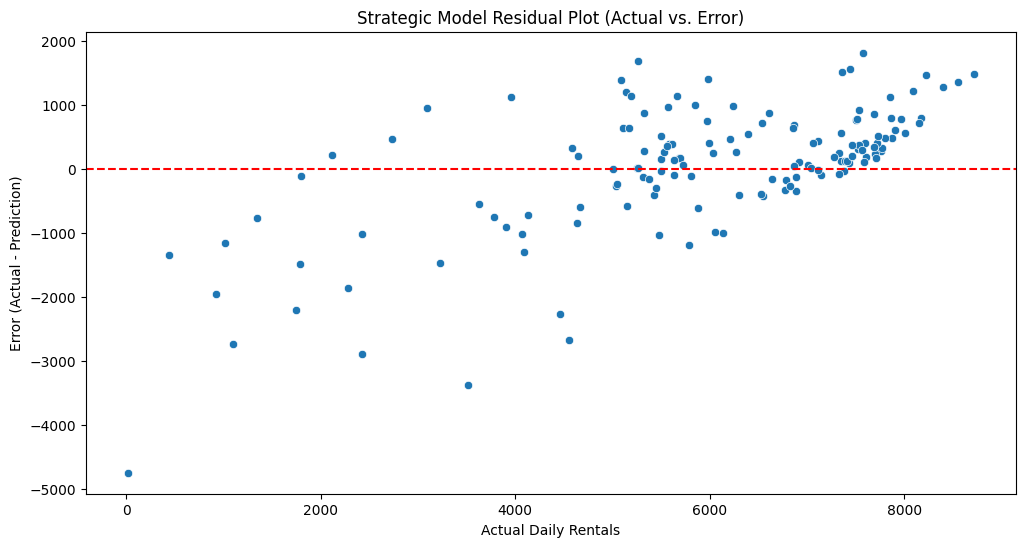

In [47]:
import seaborn as sns

# 1. Calculate Residuals
residuals = y_test - y_pred

# 2. Plot Residuals
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_test, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Strategic Model Residual Plot (Actual vs. Error)')
plt.xlabel('Actual Daily Rentals')
plt.ylabel('Error (Actual - Prediction)')
plt.show()

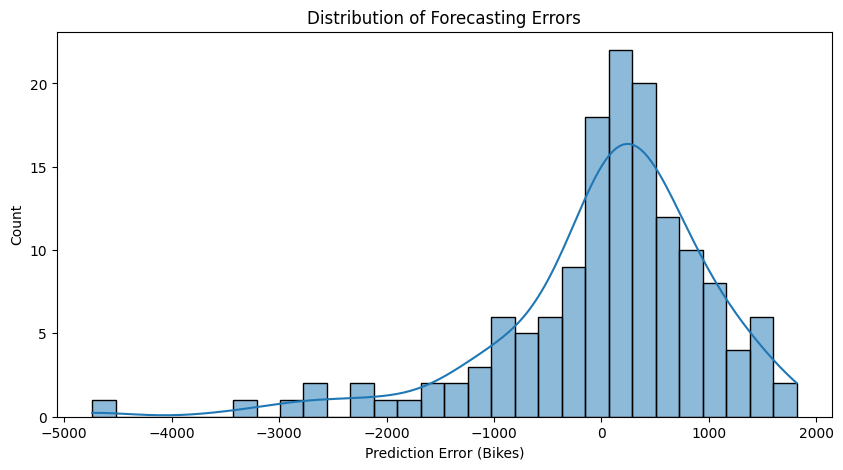

In [48]:
# 3. Distribution of Errors
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Forecasting Errors')
plt.xlabel('Prediction Error (Bikes)')
plt.show()

In [48]:
import joblib

In [49]:
# Save the trained model
joblib.dump(rf_model, 'bikeshare_strategic_rf_model.pkl')


['bikeshare_strategic_rf_model.pkl']

In [50]:
# 2. Save the Scaler used for the Daily Data
# IMPORTANT: This must be the scaler fitted on X_train (day.csv)
joblib.dump(scaler, 'bikeshare_strategic_scaler.pkl')

print("Strategic assets saved: 'bikeshare_strategic_rf_model.pkl' and 'bikeshare_strategic_scaler.pkl'")

Strategic assets saved: 'bikeshare_strategic_rf_model.pkl' and 'bikeshare_strategic_scaler.pkl'


In [56]:
# Load the saved assets
model = joblib.load('bikeshare_strategic_rf_model.pkl')
scaler = joblib.load('bikeshare_strategic_scaler.pkl')

In [57]:
# 2. Define the inputs for a specific day
# We'll simulate a Friday (weekday_4) in Autumn (season_4)
test_day_data = {
    'year': 2012, 'holiday': 0, 'workingday': 1,
    'temperature': 0.45, 'humidity': 0.60, 'windspeed': 0.15,
    'temp_rolling_7d': 0.42, 'rentals_yesterday': 4500,
    'rentals_last_week': 4300, 'days_since_start': 720,
    'is_severe_weather': 0, 'quarter': 4, 'month': 11,
    'weekday': 4, 'season': 4
}

In [58]:
# 3. Align Columns (The "Sync" Step)
df_test = pd.DataFrame([test_day_data])
df_test_encoded = pd.get_dummies(df_test, columns=['season', 'weekday', 'month', 'quarter'])

In [59]:
# THE IMPORTANT STEP: Match the 37 columns the model expects
model_features = model.feature_names_in_ 
df_test_final = df_test_encoded.reindex(columns=model_features, fill_value=0)

In [61]:
cols_to_scale = ['temperature', 'humidity', 'windspeed', 'temp_rolling_7d', 
                 'rentals_yesterday', 'rentals_last_week', 'days_since_start']

df_test_final[cols_to_scale] = scaler.transform(df_test_final[cols_to_scale])

In [62]:
# Now 'model' is defined, so this will work:
prediction = model.predict(df_test_final)
print(f"--- Strategic Prediction ---")
print(f"Predicted Total Rentals: {int(prediction[0])} bikes")

--- Strategic Prediction ---
Predicted Total Rentals: 2504 bikes
